In [1]:
from matplotlib        import collections             as matcoll
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy
from adjustText        import adjust_text

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys




import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

sys.path.append(main_path)
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()

### Settings

### Manual Test on the CPHFitter

I have change the original code based on the assumption that we have just train(0), test(1), additional(2) datasets. If you want to check use it, be sure about the changes or use survival.py file based on the an extra validation set.

In [2]:
import numpy as np
from decimal import Decimal
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Survival libs.
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter



In [3]:
# Divide group into X buckets.
def get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2):
	labels_buckets = list(range(q_buckets))
	high_lows = list()
	for index, set_data in enumerate(zip(datas, predictions)):
		data, prediction = set_data
		if data[0] is None:
			high_lows.append((None, None, None))
			continue
		current_hazard                     = data[0].copy(deep=True)
		current_hazard['hazard']           = prediction[0]
		if index == 0:
			# median_cutoff is the median hazard value of the train set
			median_cutoff = current_hazard['hazard'].median()
		# If the hazard is higher than the median, it is high risk, otherwise it is low risk.
		current_hazard['h_bin']            = (current_hazard['hazard']>median_cutoff)*1
		current_hazard['h_bin_%s' % fold]  = (current_hazard['hazard']>median_cutoff)*1
		current_low_risk_slides            = current_hazard[current_hazard['h_bin']==labels_buckets[0]][matching_field].values
		current_high_risk_slides           = current_hazard[current_hazard['h_bin']==labels_buckets[1]][matching_field].values

		high_risk_df = current_hazard[current_hazard[matching_field].isin(current_high_risk_slides)].copy(deep=True)
		low_risk_df  = current_hazard[current_hazard[matching_field].isin(current_low_risk_slides)].copy(deep=True)
		high_lows.append((low_risk_df, high_risk_df, current_hazard))
	return high_lows

In [34]:
from lifelines.plotting import add_at_risk_counts

def plot_KM_high_low(high_risk_df, low_risk_df, ax_title, ax, event_ind_field, event_data_field, max_months=None):
    

    fontsize_title  = 15
    fontsize_labels = 11
    fontsize_ticks  = 11
    fontsize_legend = 10
    l_markerscale   = 8
    l_box_w         = 3
    


    kmf_l = KaplanMeierFitter(label='Low-Risk')
    kmf_l.fit(low_risk_df[event_data_field].astype(float),  event_observed=low_risk_df[event_ind_field].astype(float))
    kmf_h = KaplanMeierFitter(label='High-Risk')
    kmf_h.fit(high_risk_df[event_data_field].astype(float), event_observed=high_risk_df[event_ind_field].astype(float))

    kmf_l.plot_survival_function(show_censors=True, ci_show=True, ax=ax)
    kmf_h.plot_survival_function(show_censors=True, ci_show=True, ax=ax)

    ax.set_title(ax_title)
    ax.set_ylim([0.0,1.10])
    ax.patch.set_linewidth(1)
    if max_months is not None:
        ax.set_xlim([0.0, max_months])
    
    for ticks in [ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()]:
        for tick in ticks:
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label1.set_fontweight('bold')

    
    ax.set_title(ax_title, fontsize=fontsize_title, fontweight='bold', y=1.02)

    ax.set_xlabel('Time (Month)',         fontsize=fontsize_labels)
    ax.set_ylabel('Survival Probability', fontsize=fontsize_labels)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

    legend = ax.legend(loc='best', markerscale=l_markerscale, title='Risk Group', prop={'size': fontsize_legend})
    legend.get_title().set_fontsize(fontsize_legend)
    legend.get_frame().set_linewidth(l_box_w)
    for line in legend.get_lines():
        line.set_linewidth(l_markerscale)
    
    add_at_risk_counts(kmf_l, kmf_h, ax=ax, ypos= -0.8)
    plt.tight_layout()


def plot_k_fold_cv_KM(high_risk, low_risk, title, max_months, event_ind_field, event_data_field, file_path=None):
    results = logrank_test(high_risk[event_data_field].astype(float), low_risk[event_data_field].astype(float), event_observed_A=high_risk[event_ind_field].astype(float), event_observed_B=low_risk[event_ind_field].astype(float))
    title_add = 'P-Value: %.2E ' % (Decimal(results.p_value))
    mosaic = '''A'''
    fig = plt.figure(figsize=(12,6.6), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic)
    plot_KM_high_low(high_risk, low_risk, ax_title=title + title_add, ax=ax_dict['A'], event_ind_field=event_ind_field, event_data_field=event_data_field, max_months=max_months)
    # plt.savefig(file_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return results.p_value

def save_fold_KMs(train_risk, risk_groups, additional_risk, resolution, groupby, cis, event_ind_field, event_data_field, max_months, cox_cluster_path):
    train_cindex = np.round(cis[0],2)
    title = 'Leiden %s EMM Set \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_train.jpg' % (str(groupby).replace('.', 'p')))
    train_pval = plot_k_fold_cv_KM(train_risk[1], train_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)
   
    test_cindex = np.round(cis[1],2)
    # title = 'Leiden %s\nC-Index Test: %s \n' % (resolution, test_cindex)
    title = 'Leiden %s Test Set \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_test.jpg' % (str(groupby).replace('.', 'p')))
    test_pval = plot_k_fold_cv_KM(risk_groups[1], risk_groups[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    additional_pval = None
    
    additional_cindex = np.round(cis[2],2)
    # title = 'Leiden %s\nC-Index Additional (TCGA): %s \n' % (resolution, additional_cindex)
    title = 'Leiden %s Additional (TCGA) \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_additional.jpg' % (str(groupby).replace('.', 'p')))
    additional_pval = plot_k_fold_cv_KM(additional_risk[1], additional_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    return train_pval, test_pval, additional_pval

In [7]:
# Combine Risk Groups over the folds. In the case of additional dataset, mayority vote over folds.
def combine_risk_groups(train_risk, test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field):
	# For test set, combine the risk groups.
	train_risk[1] = pd.concat([train_risk[1], high_lows[0][1][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)
	train_risk[0] = pd.concat([train_risk[0], high_lows[0][0][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)



	test_risk[1] = pd.concat([test_risk[1], high_lows[1][1]], ignore_index=True)
	test_risk[0] = pd.concat([test_risk[0], high_lows[1][0]], ignore_index=True)

	# For additional dataset, combine the risk groups.
	if high_lows[2][2] is not None:
		# if fold == 0:
			# additional_risk = pd.concat([additional_risk, high_lows[2][2][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)
			# additional_risk['h_bin_%s'%fold] = high_lows[2][2]['h_bin_%s'%fold].values
		additional_risk[1] = pd.concat([additional_risk[1], high_lows[2][1]], ignore_index=True)
		additional_risk[0] = pd.concat([additional_risk[0], high_lows[2][0]], ignore_index= True)

		# if fold == num_folds-1:
		# 	additional_risk['risk'] = (np.mean(additional_risk[['h_bin_%s'%fold for fold in range(num_folds)]], axis=1)>0.5)*1
		# 	high_risk_df = additional_risk[additional_risk[matching_field].isin(additional_risk[additional_risk['risk']==1][matching_field].values)].copy(deep=True)
		# 	low_risk_df  = additional_risk[additional_risk[matching_field].isin(additional_risk[additional_risk['risk']==0][matching_field].values)].copy(deep=True)
		# 	additional_risk     = [low_risk_df, high_risk_df]
	else:
		additional_risk = None
	return train_risk, test_risk, additional_risk

In [28]:

event_ind_field = 'os_event_ind'
event_data_field = 'os_event_data'
resolution = 2.0
groupby        = 'leiden_%s' % resolution
fold_number = 4


# For Kaplan-Meier Plots
matching_field = 'case_Id'
num_folds = 5
dataset = 'Meso'
meta_folder = '750K'
figure_path = '{}/workflow/figures/survival/'.format(main_path)
# figure_path = main_path + '/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/cph_{}_{}'.format(dataset, meta_folder, l1_ratio, penalizer)
os.makedirs(figure_path, exist_ok=True)
# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

### Different Resolutions

In [7]:
categorical_data = False
additional = True
resolutions = ['2p0', '4p0', '7p0', '9p0']
# resolutions = ['2p0', '4p0']
categorical_cols = ['age','TNM_Stage', 'HB_score', 'type', 'Sex']
categorical_cols_additional = ['age']

penalizer = 1
l1_ratio = .02

datas = dict()
cis = dict()
cphs = dict()

for resolution in resolutions:
    # remove, hpc = dict_removal[resolution][0], dict_removal[resolution][1]
    datas[resolution] = dict()
    cphs[resolution] = dict()
    cis[resolution] = list()
    train_scores, test_scores, additional_scores = [], [], []
    for fold in range(5):
        leiden_clusters = []
        cph_ = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        train_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

        test_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

        additional_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        features = [x for x in test_df_all.columns.tolist() if x.isdigit()]
        leiden_clusters = [str(x) for x in features]

        train_df = train_df_all[leiden_clusters + [matching_field]]
        test_df = test_df_all[leiden_clusters + [matching_field]]
        additional_df = additional_df_all[leiden_clusters + [matching_field]]


        # Adding needed columns: all clusters | partly clusters | categorical data - [os_event_data, os_event_ind]
        # for cluster, removal in zip(hpc, remove):
        #     if not removal: leiden_clusters.append(str(cluster))
    
        if categorical_data: 
            meta_data_column_list = categorical_cols + [event_data_field, event_ind_field, matching_field]
            meta_data_column_list_additional = categorical_cols_additional + [event_data_field, event_ind_field, matching_field]
        else: meta_data_column_list = [event_data_field, event_ind_field, matching_field]

        meta_data = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
        meta_data = meta_data[meta_data_column_list]
        # if additional:
        #     meta_data_additional = pd.read_csv('{}/files/TCGA_files/clinical_TCGA_clean.csv'.format(main_path))
        #     meta_data_additional = meta_data_additional[meta_data_column_list_additional]

        train_df = pd.merge(train_df, meta_data, on='case_Id', how='inner')
        test_df = pd.merge(test_df, meta_data, on='case_Id', how='inner')
        for df in [train_df, test_df]:
            df.fillna(-1, inplace=True)
            df.replace('-', df.os_event_data.max(), inplace=True)
            df.os_event_data = df.os_event_data.astype(float)

        # if additional: additional_df = pd.merge(additional_df, meta_data, on='case_Id', how='inner')
        if additional: additional_df = additional_df_all
        else: additional_df = None


        datas[resolution][fold] = [(train_df,'train'), (test_df, 'test'), (additional_df, 'additional')]

        if categorical_data:           
            # data_onehot_train = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
            # data_onehot_test = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)
            for df in [train_df, test_df]:
                df['type'] = df['type'].map({'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1})
                # df['smoking_history'] = df['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})
                df['HB_score'] = df['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
                # df['wcc_score'] = df['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
                df['TNM_Stage'] = df['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
                df['Sex'] = df['Sex'].map({'Male':0, 'Female':1})
                df['age'] = df['age'].astype(float)
                df.fillna(-1, inplace=True)

            cph_.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
            train_scores.append(cph_.score(train_df, scoring_method='concordance_index'))
            test_scores.append(cph_.score(test_df, scoring_method='concordance_index'))
            if additional: additional_scores.append(cph_.score(additional_df, scoring_method='concordance_index'))

        else:
            train_df.drop(matching_field, axis=1, inplace=True)
            test_df.drop(matching_field, axis=1, inplace=True)
            if additional: additional_df.drop(matching_field, axis=1, inplace=True)

            cph_.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
            train_scores.append(cph_.score(train_df, scoring_method='concordance_index'))
            test_scores.append(cph_.score(test_df, scoring_method='concordance_index'))
            if additional: additional_scores.append(cph_.score(additional_df, scoring_method='concordance_index'))
        cphs[resolution][fold] = cph_
    cis[resolution].append(train_scores)
    cis[resolution].append(test_scores)
    if additional: cis[resolution].append(additional_scores)

# Save to CSV.
if additional: columns = ['Leiden Resolution', 'Fold', 'Train', 'Test', 'Additional']
else: columns = ['Leiden Resolution', 'Fold', 'Train', 'Test']
cis_df = pd.DataFrame(columns=columns)
for resolution in resolutions:
    for fold in range(5):
        if additional: temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], cis[resolution][2][fold]]], columns=columns)
        else: temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold]]], columns=columns)
        # temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], cis[resolution][2][fold]]], columns=columns)
        # temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], 0]], columns=columns)
        cis_df = pd.concat([cis_df, temp_row], ignore_index=True)

df_mean = cis_df.groupby(['Leiden Resolution']).mean().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
df_std = cis_df.groupby(['Leiden Resolution']).std().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
display(cis_df)
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()



,Leiden Resolution,Fold,Train,Test,Additional
0,2p0,0,0.677732,0.632494,0.669680
1,2p0,1,0.675901,0.610101,0.648588
2,2p0,2,0.673082,0.656430,0.656874
3,2p0,3,0.667773,0.693213,0.643691
4,2p0,4,0.667067,0.676334,0.641431
5,4p0,0,0.692349,0.638288,0.702072
6,4p0,1,0.690594,0.613244,0.649718
7,4p0,2,0.688981,0.656892,0.658380
8,4p0,3,0.680912,0.691961,0.641808
9,4p0,4,0.684366,0.686079,0.645951


,Leiden Resolution,Train,Test,Additional
0,2p0,0.67 ± 0.0,0.65 ± 0.03,0.65 ± 0.01
1,4p0,0.69 ± 0.0,0.66 ± 0.03,0.66 ± 0.02
2,7p0,0.7 ± 0.01,0.65 ± 0.04,0.66 ± 0.01
3,9p0,0.7 ± 0.01,0.66 ± 0.04,0.65 ± 0.02


In [19]:
fold = 4
resolution = '2p0'
meta_folder = '750K'
temp = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
temp = temp[temp['Meso_type'] != 1]
temp['os_event_ind'].value_counts()


os_event_ind
1    66
0     5
Name: count, dtype: int64

In [23]:
categorical_data = False
additional = True
# resolutions = ['2p0', '4p0', '7p0', '9p0']
resolutions = ['2p0']
categorical_cols = ['age','TNM_Stage', 'HB_score', 'type', 'Sex']
categorical_cols_additional = ['age']

penalizer = 1
l1_ratio = .02

datas = dict()
cis = dict()
cphs = dict()

for resolution in resolutions:
    # remove, hpc = dict_removal[resolution][0], dict_removal[resolution][1]
    datas[resolution] = dict()
    cphs[resolution] = dict()
    cis[resolution] = list()
    train_scores, test_scores, additional_scores = [], [], []
    for fold in range(5):
        leiden_clusters = []
        cph_ = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        train_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        # Just Sarc/Biphasic cases.
        train_df_all = train_df_all[train_df_all['Meso_type'] == 1]
        # Just Epithelioid cases.
        # train_df_all = train_df_all[train_df_all['Meso_type'] == 0]

        test_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        # Just Sarc/Biphasic cases.
        test_df_all = test_df_all[test_df_all['Meso_type'] == 1]
        # Just Epithelioid cases.
        # test_df_all = test_df_all[test_df_all['Meso_type'] == 0]

        additional_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        # Just Sarc/Biphasic cases.
        additional_df_all = additional_df_all[additional_df_all['Meso_type'] == 1]
        # Just Epithelioid cases.
        # additional_df_all = additional_df_all[additional_df_all['Meso_type'] == 0]
        

        features = [x for x in test_df_all.columns.tolist() if x.isdigit()]
        leiden_clusters = [str(x) for x in features]

        train_df = train_df_all[leiden_clusters + [matching_field]]
        test_df = test_df_all[leiden_clusters + [matching_field]]
        additional_df = additional_df_all[leiden_clusters + [matching_field]]

    
        if categorical_data: 
            meta_data_column_list = categorical_cols + [event_data_field, event_ind_field, matching_field]
            meta_data_column_list_additional = categorical_cols_additional + [event_data_field, event_ind_field, matching_field]
        else: meta_data_column_list = [event_data_field, event_ind_field, matching_field]

        meta_data = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
        meta_data = meta_data[meta_data_column_list]
        # if additional:
        #     meta_data_additional = pd.read_csv('{}/files/TCGA_files/clinical_TCGA_clean.csv'.format(main_path))
        #     meta_data_additional = meta_data_additional[meta_data_column_list_additional]

        train_df = pd.merge(train_df, meta_data, on='case_Id', how='inner')
        test_df = pd.merge(test_df, meta_data, on='case_Id', how='inner')
        for df in [train_df, test_df]:
            df.fillna(-1, inplace=True)
            df.replace('-', df.os_event_data.max(), inplace=True)
            df.os_event_data = df.os_event_data.astype(float)

        # if additional: additional_df = pd.merge(additional_df, meta_data, on='case_Id', how='inner')
        if additional: additional_df = additional_df_all
        else: additional_df = None


        datas[resolution][fold] = [(train_df,'train'), (test_df, 'test'), (additional_df, 'additional')]

        if categorical_data:           
            # data_onehot_train = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
            # data_onehot_test = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)
            for df in [train_df, test_df]:
                df['type'] = df['type'].map({'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1})
                # df['smoking_history'] = df['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})
                df['HB_score'] = df['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
                # df['wcc_score'] = df['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
                df['TNM_Stage'] = df['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
                df['Sex'] = df['Sex'].map({'Male':0, 'Female':1})
                df['age'] = df['age'].astype(float)
                df.fillna(-1, inplace=True)

            cph_.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
            train_scores.append(cph_.score(train_df, scoring_method='concordance_index'))
            test_scores.append(cph_.score(test_df, scoring_method='concordance_index'))
            if additional: additional_scores.append(cph_.score(additional_df, scoring_method='concordance_index'))

        else:
            train_df.drop(matching_field, axis=1, inplace=True)
            test_df.drop(matching_field, axis=1, inplace=True)
            if additional: additional_df.drop(matching_field, axis=1, inplace=True)

            cph_.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
            train_scores.append(cph_.score(train_df, scoring_method='concordance_index'))
            test_scores.append(cph_.score(test_df, scoring_method='concordance_index'))
            if additional: additional_scores.append(cph_.score(additional_df, scoring_method='concordance_index'))
        cphs[resolution][fold] = cph_
    cis[resolution].append(train_scores)
    cis[resolution].append(test_scores)
    if additional: cis[resolution].append(additional_scores)

# Save to CSV.
if additional: columns = ['Leiden Resolution', 'Fold', 'Train', 'Test', 'Additional']
else: columns = ['Leiden Resolution', 'Fold', 'Train', 'Test']
cis_df = pd.DataFrame(columns=columns)
for resolution in resolutions:
    for fold in range(5):
        if additional: temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], cis[resolution][2][fold]]], columns=columns)
        else: temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold]]], columns=columns)
        # temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], cis[resolution][2][fold]]], columns=columns)
        # temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], 0]], columns=columns)
        cis_df = pd.concat([cis_df, temp_row], ignore_index=True)

df_mean = cis_df.groupby(['Leiden Resolution']).mean().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
df_std = cis_df.groupby(['Leiden Resolution']).std().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
display(cis_df)
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()



,Leiden Resolution,Fold,Train,Test,Additional
0,2p0,0,0.678667,0.625000,0.688742
1,2p0,1,0.707003,0.540046,0.529801
2,2p0,2,0.682801,0.735632,0.569536
3,2p0,3,0.710698,0.550756,0.596026
4,2p0,4,0.695801,0.544262,0.509934


,Leiden Resolution,Train,Test,Additional
0,2p0,0.69 ± 0.01,0.6 ± 0.08,0.58 ± 0.07


<Axes: xlabel='Leiden Resolution', ylabel='Additional'>

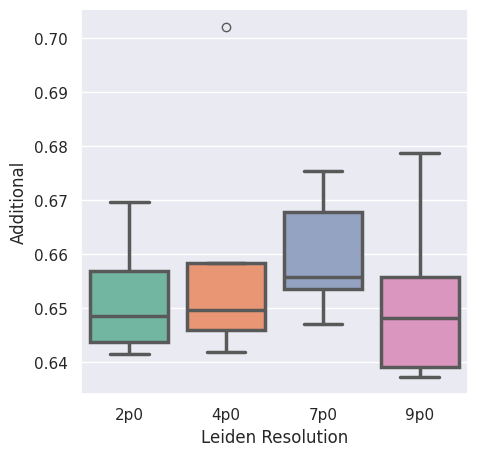

In [78]:
# making voilin plot from additional scores.
plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
sns.boxplot(data=cis_df, x="Leiden Resolution", y="Additional", linewidth=2.5, palette='Set2')
# sns.violinplot(data=cis_df, x='Leiden Resolution', y='Test', inner='quartile', color='skyblue')
# sns.violinplot(data=cis_df, x='Leiden Resolution', y='Additional', inner='quartile', color='blue')



MetaData Only

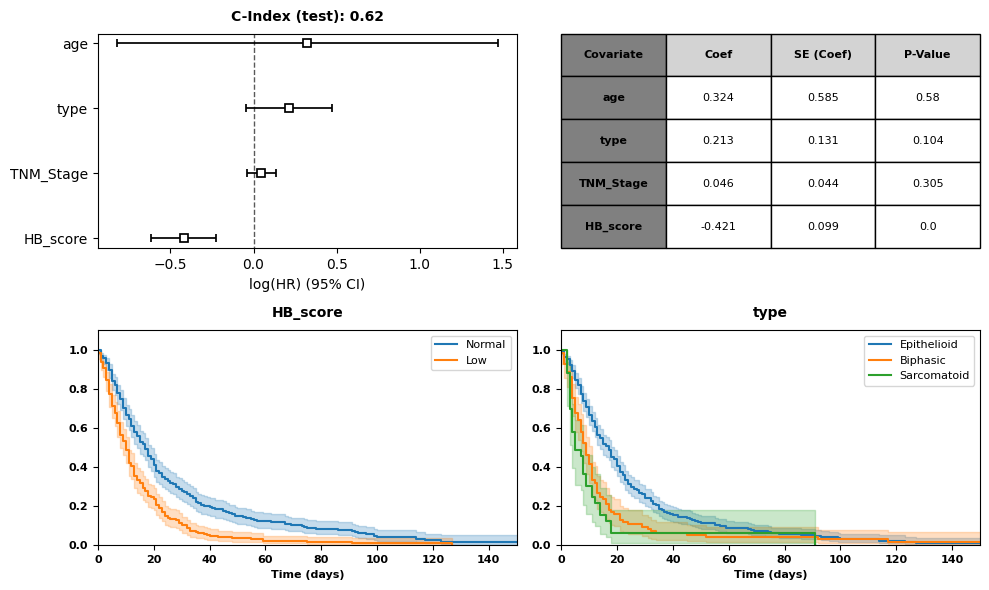

In [89]:
ncol, nrow = 2,2
fig = plt.figure(figsize=(5*ncol, 3*nrow))
gs = fig.add_gridspec(nrow, ncol)


cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
meta_data = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
event_data_field = 'os_event_data'
event_ind_field = 'os_event_ind'

# event_data_field = 'time_to_recurrence'
# event_ind_field = 'recurrence'

columns = ['age', 'type', 'HB_score', 'TNM_Stage', event_data_field, event_ind_field]

meta_data = meta_data[columns]
# meta_data = pd.get_dummies(meta_data, columns=['type', 'TNM_Stage', 'HB_score'], drop_first=False)
meta_data['age'] = meta_data['age'] / meta_data['age'].max()
meta_data['type'] = meta_data['type'].map({'Epithelioid': 0.0, 'Sarcomatoid': 2.0, 'Biphasic': 1.0})
meta_data['HB_score'] = meta_data['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
meta_data['TNM_Stage'] = meta_data['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
# meta_data['wcc_score'] = meta_data['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
# meta_data['Sex'] = meta_data['Sex'].map({'Male':0, 'Female':1})
# meta_data['smoking_history'] = meta_data['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})

meta_data.replace('-', 255, inplace=True)
meta_data[event_data_field] = meta_data[event_data_field].astype(float)

meta_data.fillna(-1, inplace=True)
meta_data_test = meta_data.sample(frac=0.4, random_state=5)
meta_data_train = meta_data[~meta_data.index.isin(meta_data_test.index)]
cph.fit(meta_data_train, duration_col=event_data_field, event_col=event_ind_field, robust=True)
ax = [fig.add_subplot(gs[0, 0:1]), fig.add_subplot(gs[0, 1:2])]
cph.plot(ax=ax[0])
c_index = cph.score(meta_data_test, scoring_method='concordance_index')
ax[0].set_title('C-Index (test): %.2f' % c_index, fontsize=10, fontweight='bold', y=1.02)

summary = cph.summary
summary = summary.reset_index()
summary = summary[['covariate', 'coef', 'se(coef)','p']]
summary = summary.sort_values('coef', ascending=False)
summary = summary.rename(columns={'covariate': 'Covariate', 'coef': 'Coef', 'se(coef)': 'SE (Coef)', 'p': 'P-Value'})
summary = summary.round(3)
mpl_table = ax[1].table(cellText=summary.values, colLabels=summary.columns, cellLoc = 'center', loc='center', bbox=[0, 0, 1, 1])
# mpl_table.set_fontsize(20)
ax[1].axis('off')
for key, cell in mpl_table._cells.items():
    cell.set_linewidth(1)
    if key[0] == 0: # headers or columns
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgray')
    if key[1] == 0:# rows
        cell.set_text_props(weight='bold')
        cell.set_facecolor('gray')


############################################################################################################# 
ax = [fig.add_subplot(gs[1, 0:1]), fig.add_subplot(gs[1, 1:2])]
label_dict = {'HB_score':{'Low': 0, 'Normal': 1, 'High': 2, '99': -1}, 'TNM_Stage':{'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1}, 'type':{'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1}}
reversed_label_dict = {k: {v: k for k, v in v.items()} for k, v in label_dict.items()}
# do the same for the other categorical variables
for i, col in enumerate(['HB_score', 'type']):
    kmf = KaplanMeierFitter()
    for val in meta_data[col].unique():
        group = meta_data[meta_data[col] == val]
        kmf.fit(group[event_data_field], group[event_ind_field], label=val)
        label = reversed_label_dict[col][val]
        if label in ['Low', 'Normal', 'IA', 'IB', 'II', 'IIIA', 'IIIB', 'Epithelioid', 'Sarcomatoid', 'Biphasic']:
            kmf.plot(ax=ax[i], label=label)
    for ticks in [ax[i].xaxis.get_major_ticks(), ax[i].yaxis.get_major_ticks()]:
        for tick in ticks:
            tick.label1.set_fontsize(8)
            tick.label1.set_fontweight('bold')
    ax[i].set_title(col, fontsize=10, fontweight='bold', y=1.02)
    ax[i].set_xlabel('Time (days)', fontsize=8, fontweight='bold')
    ax[i].legend(loc='best', fontsize=8)
    ax[i].set_ylim([0.0,1.10])
    ax[i].set_xlim([0.0, 150])

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'metadata_cph_summary.jpg'), dpi=500, bbox_inches='tight')


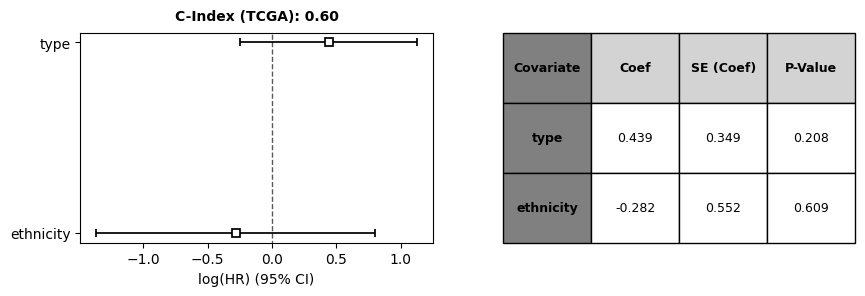

In [68]:
# For TCGA
ncol, nrow = 2,2
fig = plt.figure(figsize=(5*ncol, 3*nrow))
gs = fig.add_gridspec(nrow, ncol)


cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
meta_data = pd.read_csv('{}/files/TCGA_files/clinical_TCGA_clean.csv'.format(main_path))
event_data_field = 'os_event_data'
event_ind_field = 'os_event_ind'

# event_data_field = 'time_to_recurrence'
# event_ind_field = 'recurrence'

columns = ['type', 'ethnicity',event_data_field, event_ind_field]

meta_data = meta_data[columns]

# meta_data = pd.get_dummies(meta_data, columns=['morphology'], drop_first=False)

# meta_data['age'] = meta_data['age'] / meta_data['age'].max()
# meta_data['morphology'] = meta_data['morphology'].map({'9052/3':2, '9053/3':3, '9050/3':0, '9051/3':1 })
meta_data['type'] = meta_data['type'].map({'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1})
# meta_data['race'] = meta_data['race'].map({'white': 0, 'black or african american': 1, 'asian': 2})
meta_data['ethnicity'] = meta_data['ethnicity'].map({'not hispanic or latino': 0, 'not reported': -1})
# meta_data['prior_treatment'] = meta_data['prior_treatment'].map({'Yes': 1, 'No': 0})
# meta_data['ajcc_pathologic_m'] = meta_data['ajcc_pathologic_m'].map({'M0': 0, 'M1': 1, 'MX': -1})
# meta_data['Stage'] = meta_data['Stage'].map({'N0': 0, 'N1':1, 'N2': 2, 'N3': 3, 'NX': 0})
# meta_data['Sex'] = meta_data['Sex'].map({'male':0, 'female':1})

meta_data.replace("'--", 255, inplace=True)
meta_data[event_data_field] = meta_data[event_data_field].astype(float)
meta_data.fillna(-1, inplace=True)
meta_data_test = meta_data.sample(frac=0.4, random_state=5)
meta_data_train = meta_data[~meta_data.index.isin(meta_data_test.index)]
cph.fit(meta_data_train, duration_col=event_data_field, event_col=event_ind_field, robust=True)
ax = [fig.add_subplot(gs[0, 0:1]), fig.add_subplot(gs[0, 1:2])]
cph.plot(ax=ax[0])
c_index = cph.score(meta_data_test, scoring_method='concordance_index')
ax[0].set_title('C-Index (TCGA): %.2f' % c_index, fontsize=10, fontweight='bold', y=1.02)

summary = cph.summary
summary = summary.reset_index()
summary = summary[['covariate', 'coef', 'se(coef)','p']]
summary = summary.sort_values('coef', ascending=False)
summary = summary.rename(columns={'covariate': 'Covariate', 'coef': 'Coef', 'se(coef)': 'SE (Coef)', 'p': 'P-Value'})
summary = summary.round(3)
mpl_table = ax[1].table(cellText=summary.values, colLabels=summary.columns, cellLoc = 'center', loc='center', bbox=[0, 0, 1, 1])
# mpl_table.set_fontsize(20)
ax[1].axis('off')
for key, cell in mpl_table._cells.items():
    cell.set_linewidth(1)
    if key[0] == 0: # headers or columns
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgray')
    if key[1] == 0:# rows
        cell.set_text_props(weight='bold')
        cell.set_facecolor('gray')


############################################################################################################# 
# ax = [fig.add_subplot(gs[1, 0:1]), fig.add_subplot(gs[1, 1:2])]
# label_dict = {'HB_score':{'Low': 0, 'Normal': 1, 'High': 2, '99': -1}, 'TNM_Stage':{'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1}, 'type':{'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1}, 'Stage':{'N0': 0, 'N1':1, 'N2': 2, 'N3': 3, 'NX': 0}, 'Sex':{'male':0, 'female':1}}
# reversed_label_dict = {k: {v: k for k, v in v.items()} for k, v in label_dict.items()}
# # do the same for the other categorical variables
# for i, col in enumerate(['type', 'Stage']):
#     kmf = KaplanMeierFitter()
#     for val in meta_data[col].unique():
#         group = meta_data[meta_data[col] == val]
#         kmf.fit(group[event_data_field], group[event_ind_field], label=val)
#         label = reversed_label_dict[col][val]
#         if label in ['Low', 'Normal', 'IA', 'IB', 'II', 'IIIA', 'IIIB', 'Epithelioid', 'Sarcomatoid', 'Biphasic']:
#             kmf.plot(ax=ax[i], label=label)
#     for ticks in [ax[i].xaxis.get_major_ticks(), ax[i].yaxis.get_major_ticks()]:
#         for tick in ticks:
#             tick.label1.set_fontsize(8)
#             tick.label1.set_fontweight('bold')
#     ax[i].set_title(col, fontsize=10, fontweight='bold', y=1.02)
#     ax[i].set_xlabel('Time (days)', fontsize=8, fontweight='bold')
#     ax[i].legend(loc='best', fontsize=8)
#     ax[i].set_ylim([0.0,1.10])
#     ax[i].set_xlim([0.0, 150])

# plt.tight_layout()
# plt.savefig(os.path.join(figure_path, 'metadata_cph_summary_tcga.jpg'), dpi=500, bbox_inches='tight')


### HPL-MIL Score

In [25]:
# Removing the clusters manually
# leiden 1p5 fold 4
remove_1p5 = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
hpc_1p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

# leiden 2p0 fold 4
hpc_2p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
remove_2p0 = [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 
# back to normal to get the association with all the clusters for the HR plot
remove_2p0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 2p5 fold 4
hpc_2p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
remove_2p5 = [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# leiden 3p0 fold 4
hpc_3p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
remove_3p0 = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 4p0 fold 4
hpc_4p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
remove_4p0 = [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

dict_removal = {'1p5':[remove_1p5, hpc_1p5], '2p0':[remove_2p0, hpc_2p0], '2p5':[remove_2p5, hpc_2p5], '3p0':[remove_3p0, hpc_3p0], '4p0':[remove_4p0, hpc_4p0]}

Fixing res=2.0 and fold=4

	 Resolution: 2p0


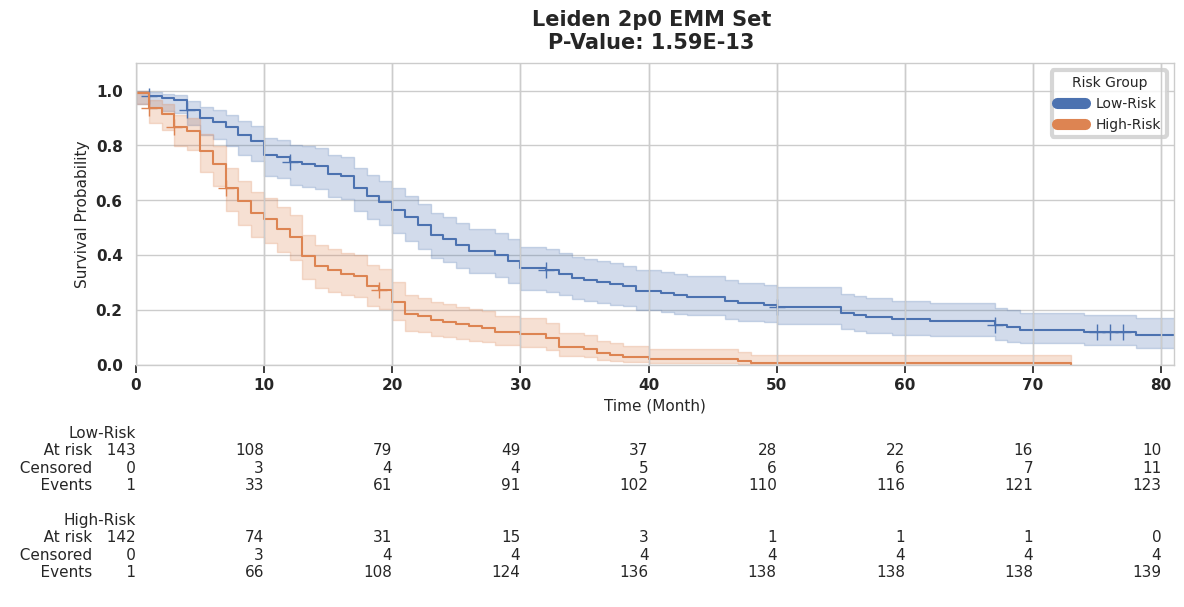

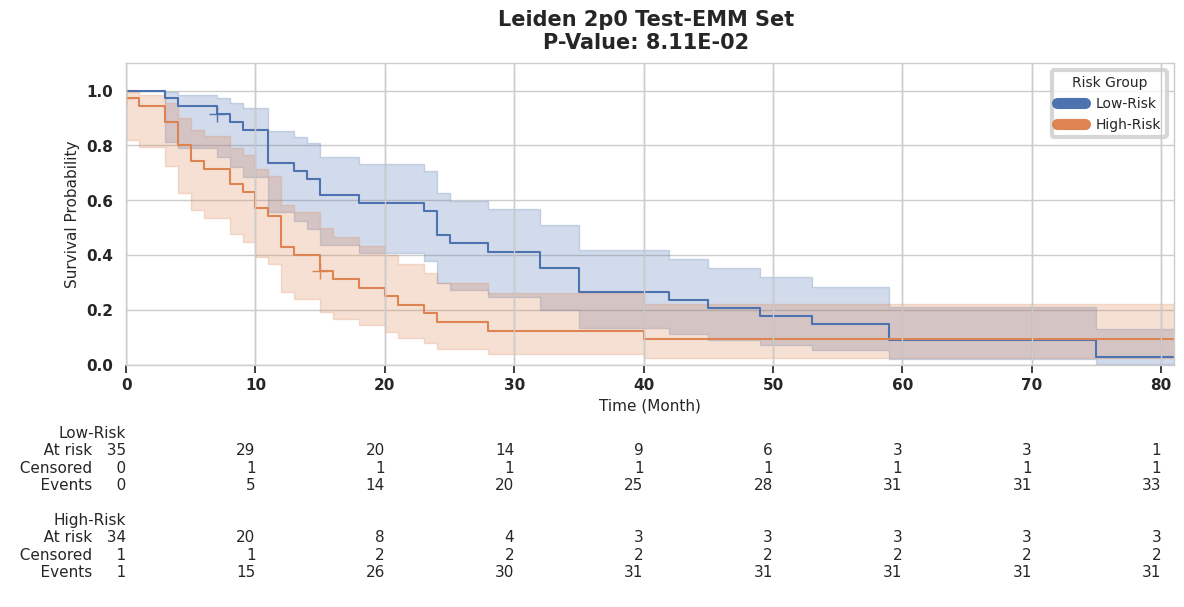

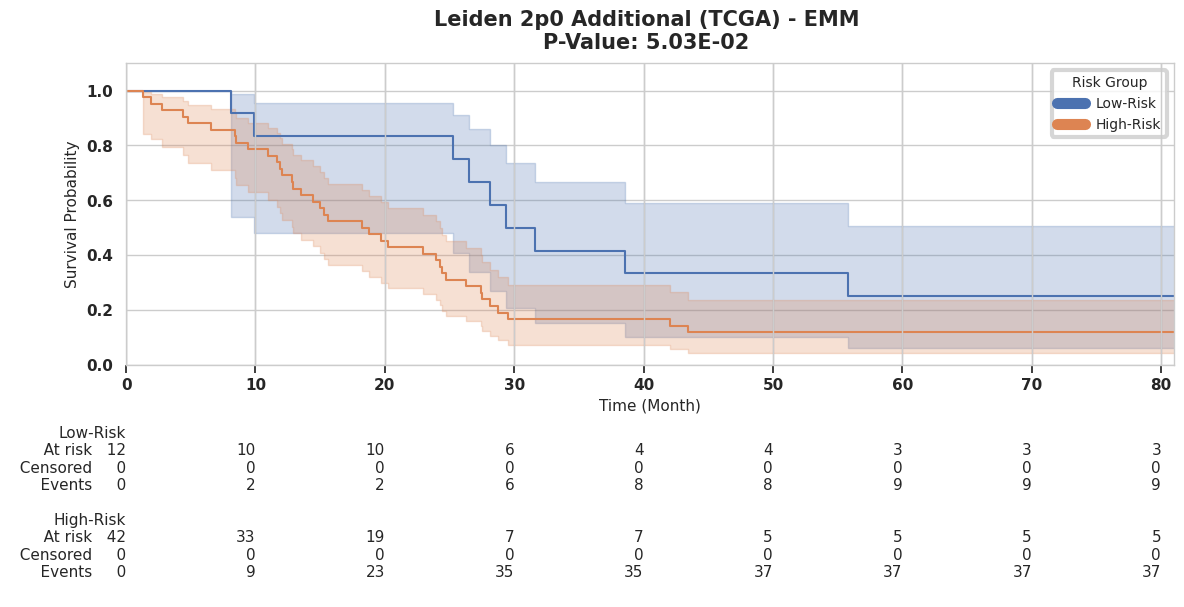

In [35]:
penalizer = .5
l1_ratio = .1
sns.set_theme(style="whitegrid")
# resolutions = ['1p5', '2p0', '2p5', '3p0', '4p0']
resolutions = ['2p0']
for resolution in resolutions:
        cis_list = []
        fold = 4
        train_risk = [pd.DataFrame(), pd.DataFrame()]
        test_risk = [pd.DataFrame(), pd.DataFrame()]
        additional_risk = [pd.DataFrame(), pd.DataFrame()]

        train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        # Just Sarc/Biphasic cases.
        # train = train[train['Meso_type'] == 1]
        # Just Epithelioid cases.
        train = train[train['Meso_type'] == 0]


        test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        # Just Sarc/Biphasic cases.
        # test = test[test['Meso_type'] == 1]
        # Just Epithelioid cases.
        test = test[test['Meso_type'] == 0]

        additional = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        # Just Sarc/Biphasic cases.
        # additional = additional[additional['Meso_type'] == 1]
        # Just Epithelioid cases.
        additional = additional[additional['Meso_type'] == 0]


        # remove this column from the train and test data
        leiden_clusters = []
        hpc, remove = dict_removal[resolution][1], dict_removal[resolution][0]
        for cluster, removal in zip(hpc, remove):
                if not removal: leiden_clusters.append(str(cluster))

        train_df = train[leiden_clusters + [event_data_field, event_ind_field]]
        test_df = test[leiden_clusters + [event_data_field, event_ind_field]]
        additional_df = additional[leiden_clusters + [event_data_field, event_ind_field]]
        features = [x for x in train_df.columns.tolist() if x.isdigit()]
        leiden_clusters = [str(x) for x in features]

        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        cph.fit(train_df, duration_col=event_data_field, event_col=event_ind_field, robust=True)
        print('\t Resolution: {}'.format(resolution))
        cis_list.append(cph.score(train_df, scoring_method='concordance_index'))
        cis_list.append(cph.score(test_df, scoring_method='concordance_index'))
        cis_list.append(cph.score(additional_df, scoring_method='concordance_index'))

        train_df = train[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
        test_df = test[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
        additional_df = additional[leiden_clusters + [event_data_field, event_ind_field, matching_field]]

        datas = [(train_df, 'train'), (test_df, 'test'), (additional_df, 'additional')]

        train_preds = cph.predict_partial_hazard(train_df)
        test_preds = cph.predict_partial_hazard(test_df)
        additional_preds = cph.predict_partial_hazard(additional_df)

        predictions = [(train_preds,'train'), (test_preds,'test'), (additional_preds,'additional')]


        high_lows = get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2)
        # test_risk, additional_risk = combine_risk_groups(test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field)
        train_risk, test_risk, additional_risk = combine_risk_groups(train_risk, test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field)

        train_pval, test_pval, additional_pval = save_fold_KMs(train_risk, test_risk, additional_risk, resolution, 'leiden_{}'.format(resolution.replace('p','.')), np.array(cis_list), event_ind_field, event_data_field, 9*9, figure_path)



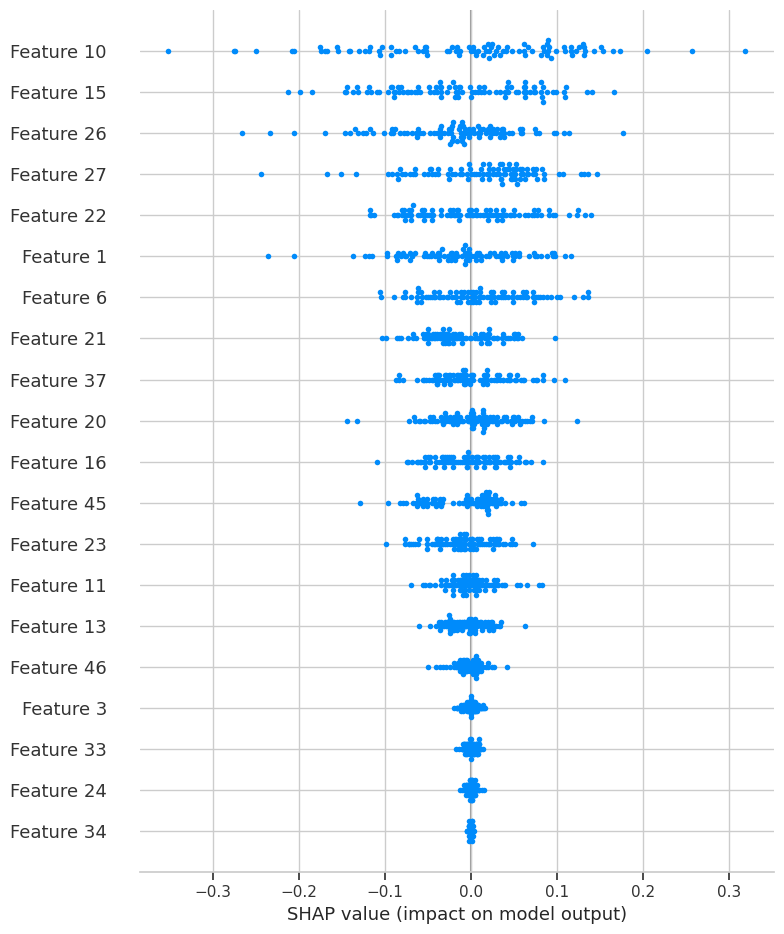

In [22]:
# SHAP
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(cph.predict_log_partial_hazard, train_df[features], max_samples=train_df.shape[0])
shap_values = explainer.shap_values(test_df[features])
shap.summary_plot(shap_values)

In [23]:
summary = cph.summary.reset_index()
h5_path_adata = h5_complete_path
meta_folder_adata = '750K'
groupby = 'leiden_2.0'
fold_number = 4
if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))
adata_train.obs['HR'] = adata_train.obs['leiden_2.0'].apply(lambda x: summary[summary['covariate'].astype(str) == str(x)]['exp(coef)'].values[0]).astype(float)



In [26]:
df_hr = summary[['covariate', 'exp(coef)', 'p']]
df_hr = df_hr.rename(columns={'covariate': 'HPC', 'exp(coef)': 'HR_survival', 'p': 'P_value_survival'})
df_hr.to_csv(os.path.join(figure_path, 'hr_survival_2p0_fold4.csv'), index=False)

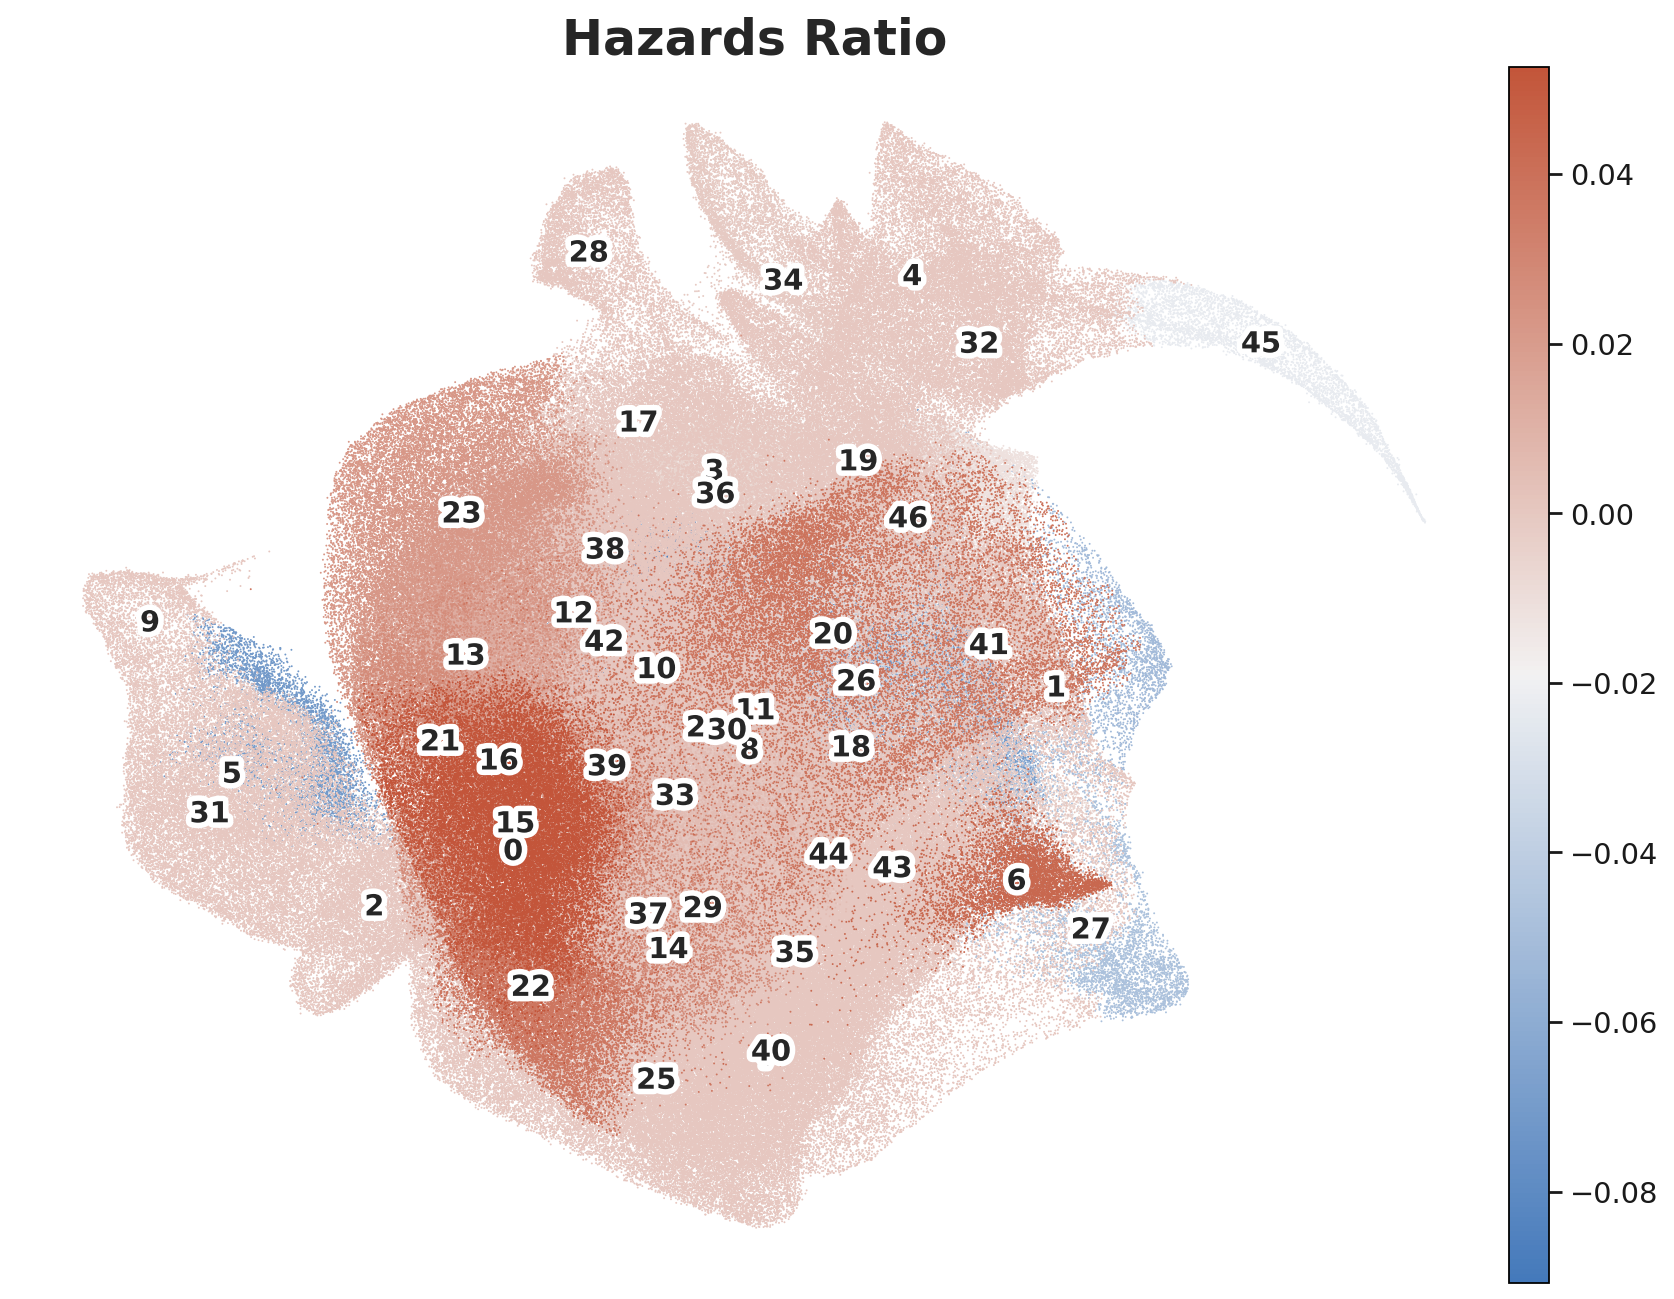

In [22]:
fig = plt.figure(figsize=(13,10))
ax1 = fig.add_subplot(111)
sc.set_figure_params(fontsize=13)
sc.pl.umap(adata_train, color='HR', show=False, size=3,  frameon=False, cmap=sns.diverging_palette(250, 20, as_cmap=True), title='Hazards Ratio', ax=ax1);
# ax2 = fig.add_subplot(122)
sc.pl.umap(adata_train, color='leiden_2.0', show=False, size=3,  frameon=False, title='Leiden Clusters', ax=ax1, legend_loc='on data', palette='tab20', alpha=0.0, legend_fontoutline = 5, legend_fontsize=13);
# ax2.set_title('Leiden Cluster Numbers', fontsize=20)
ax1.set_title('Hazards Ratio', fontsize=22, weight='bold');
plt.savefig('{}/HR_leiden_clusters.png'.format(figure_path), dpi=500, bbox_inches='tight')


# Cluster Significance

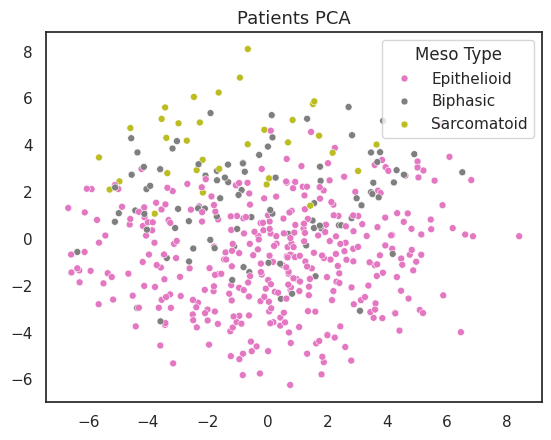

In [89]:
df = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
temp = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
df = pd.concat([df, temp], axis=0)
# add metadata to df
meta = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
df = df.merge(meta, on='case_Id', how='inner')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
reducer = PCA(n_components=2)
# reducer = umap.UMAP(random_state=42 , n_neighbors=100, min_dist=0, verbose=False)
X = df[features].values
X = StandardScaler().fit_transform(X)
X = reducer.fit_transform(X)
palette = sns.color_palette('tab10')[-4:]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=df.type, palette=palette, s=25, alpha=1.0)
plt.legend(loc='upper right', title='Meso Type')
plt.title('Patients PCA', fontsize=13)
plt.savefig('{}/pca_patients_type.png'.format(figure_path), dpi=500, bbox_inches='tight')
plt.show()


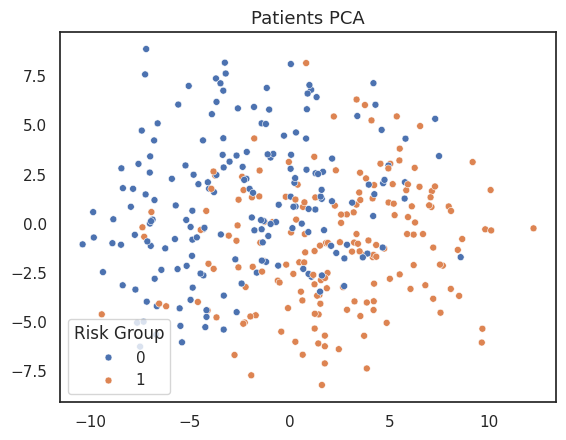

In [88]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
# for train and test data
temp = pd.concat([high_lows[0][1], high_lows[0][0], high_lows[1][1], high_lows[1][0]], axis=0)
# reducer = umap.UMAP(random_state=42 , n_neighbors=100, min_dist=0, verbose=False)
# using pca instead of umap
from sklearn.decomposition import PCA
reducer = PCA(n_components=2)


embedding = reducer.fit_transform(temp.drop(['h_bin','h_bin_4', 'hazard', 'os_event_data',	'os_event_ind'	,'case_Id'], axis=1).values)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=temp.h_bin, s=25, alpha=1.0);
plt.legend(loc='lower left', title='Risk Group')
# plt.title('Patients UMAP', fontsize=13)
plt.title('Patients PCA', fontsize=13)
# plt.savefig('{}/umap_patients.png'.format(figure_path), dpi=500, bbox_inches='tight')
plt.savefig('{}/pca_patients.png'.format(figure_path), dpi=500, bbox_inches='tight')

### Forest Plots

In [36]:
# Reading annotations.
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

#  resoltuion 2.0 and Fold 0
model = cph
results_df = model.summary
results_df['hpc'] = results_df.index
results_df = results_df.sort_values(by='coef', ascending=False).reset_index(drop=True)


significance = 0.05
results_df_signfcnt = results_df[results_df['p'] < significance]
death_clusters = results_df_signfcnt[results_df_signfcnt['coef'] > 0].sort_values(by='coef', ascending=False)
alive_clusters = results_df_signfcnt[results_df_signfcnt['coef'] < 0].sort_values(by='coef', ascending=True)
print('Death clusters: ', death_clusters['hpc'].values)
print('Alive clusters: ', alive_clusters['hpc'].values)




# export needed tiles
im_list_dict = dict()
for class_ in ['death', 'alive']:
    im_list = []
    if class_ == 'death': cluster_set = death_clusters.hpc.astype('str')
    elif class_ == 'alive': cluster_set = alive_clusters.hpc.astype('str')
    for cluster_number in cluster_set:
        # if cluster_number.split('_')[0] in categorical_cols: im_list.append((None, cluster_number))
        # else:
        indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
        i_rand = np.random.randint(0, len(indexes))
        index_ = indexes[i_rand]
        set_ = sets[i_rand]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
        h5_image.close()
    im_list_dict[class_] = im_list

Death clusters:  ['22']
Alive clusters:  ['10']


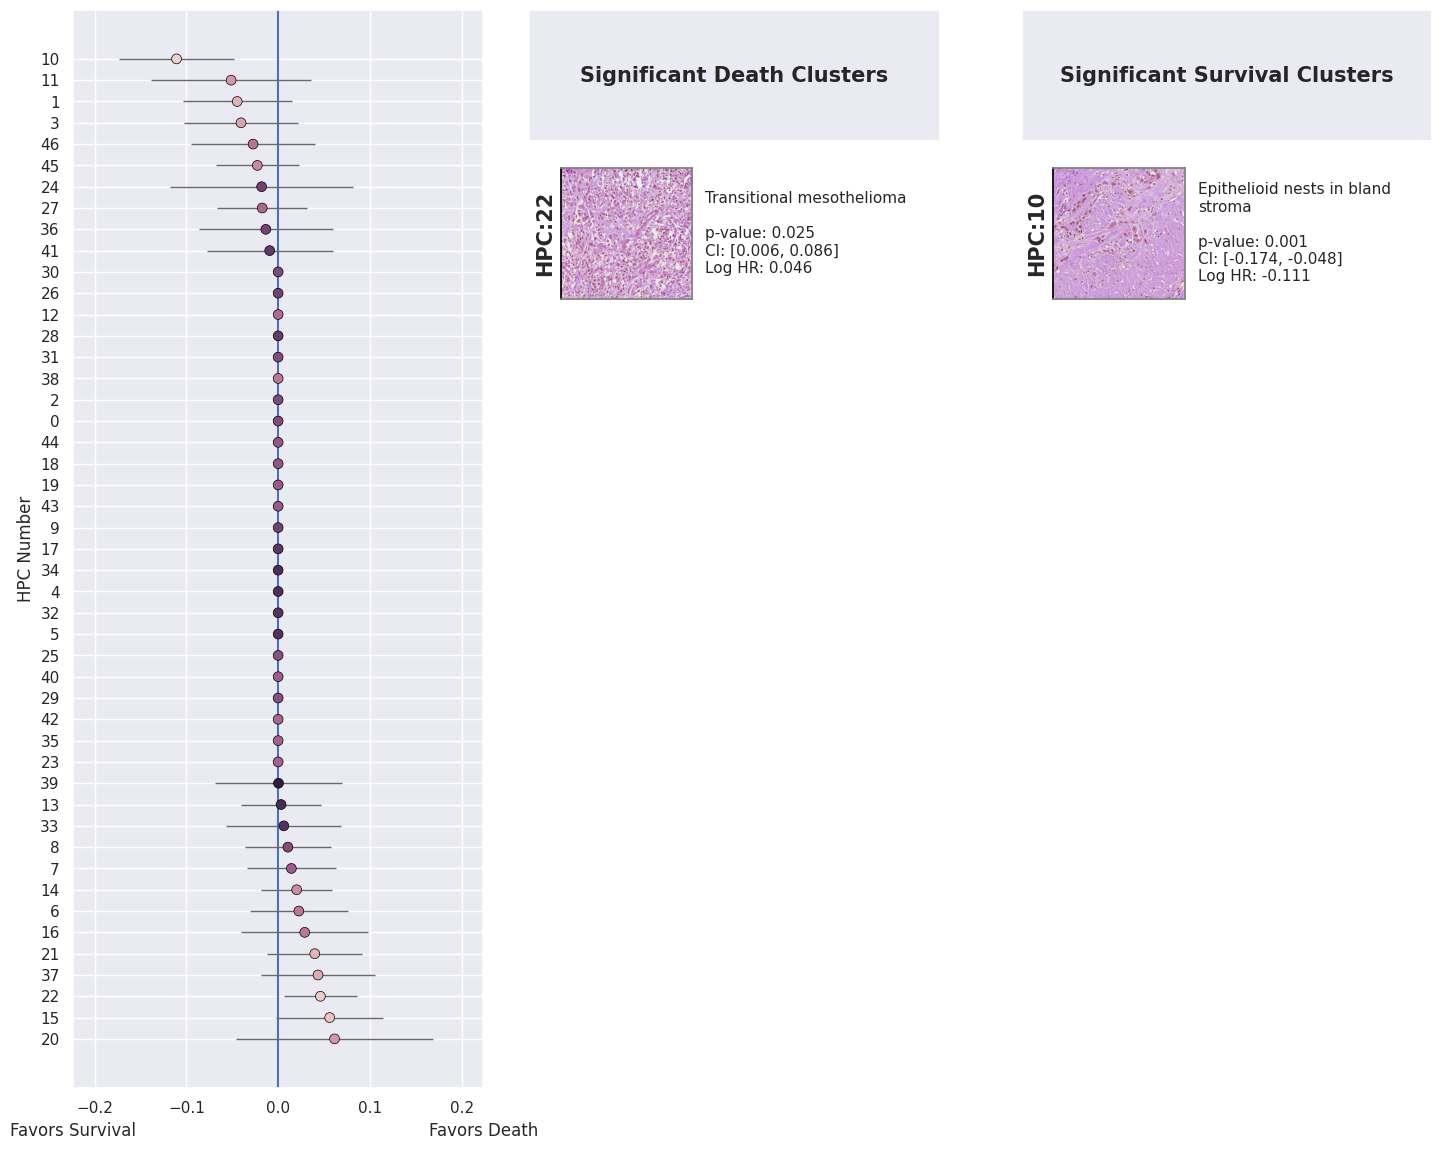

In [37]:
import textwrap
sns.set_style("darkgrid")

#  Forest Plot
center = 0.0
effect_measure = results_df['coef'].values.astype(str).astype(float)
lower = results_df['coef lower 95%'].values
upper = results_df['coef upper 95%'].values
diff_upper = upper - effect_measure
diff_lower = effect_measure - lower

ncol, nrow = 3, 7
fig = plt.figure(figsize=(6*ncol, 2*nrow))
gs = fig.add_gridspec(nrow, ncol)
ax1 = fig.add_subplot(gs[:, 0])


fontsize = 12
plot = sns.scatterplot(data=results_df, x='coef', y=results_df.index, hue='p', sizes=(20, 200), legend=False, zorder=3, edgecolor='black', linewidth=0.5, s=50, ax=ax1)
plot.set_yticklabels(results_df['hpc'])
plot.set_yticks(results_df.index)
plot.axvline(center, zorder=1)
plot.errorbar(effect_measure, results_df.index, xerr=[diff_upper, diff_lower], marker='None',zorder=2, ecolor='dimgrey', elinewidth=1, linewidth=0)

plot.set_xlabel('', fontsize=fontsize)
plot.set_ylabel('HPC Number', fontsize=fontsize)
max_value = max(abs(max(upper)), abs(min(lower)))
plot.set_xlim([-max_value-.05, max_value+.05])
plot.text(0.0, -.04, textwrap.fill('Favors Survival',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize)
plot.text(1.0, -.04, textwrap.fill('Favors Death',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize);
################################################################################################################################ 



# Legends
annot_flag = True
for class_ in ['death', 'alive']:
    im_list = im_list_dict[class_]
    if class_=='death': 
        i, j = 0, 1
        title = 'Significant Death Clusters'
    else: 
        i, j = 0, 2
        title = 'Significant Survival Clusters'
    ax = fig.add_subplot(gs[i,j])
    ax.set(xticks=[], yticks=[])
    ax.text(0.5, 0.5, textwrap.fill(title, 30), fontsize=15, ha='center', va='center', weight='bold')
    pos = ax.get_position()
    ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
    i+=1

    for (image, cluster_number) in im_list:
        ax = fig.add_subplot(gs[i, j])
        if image is not None:
            ax.imshow(image)
        else:
            cluster_number = cluster_number.split('_')[0]
        ax.set(xticks=[], yticks=[])
        # ax.set_title('Cluster {}'.format(cluster_number), fontsize=fontsize)
        i += 1

        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=15))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])

        p_value = results_df[results_df['hpc']==cluster_number]['p'].values[0]
        log_HR = results_df[results_df['hpc']==cluster_number]['coef'].values[0]
        CI = [results_df[results_df['hpc']==cluster_number]['coef lower 95%'].values[0], results_df[results_df['hpc']==cluster_number]['coef upper 95%'].values[0]]
        # if cluster_number.split('_')[0] in categorical_cols: 
            # label_text = 'Feature: {}'.format(cluster_number)
        # else:
        if annot_flag: annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
        else: annotation_text = ''
        label_text = annotation_text + '\n \n'+ 'p-value: {}'.format(np.round(p_value, 3)) + '\n' + 'CI: [{}, {}]'.format(np.round(CI[0], 3), np.round(CI[1], 3)) + '\n' + 'Log HR: {}'.format(np.round(log_HR, 3))
        
        ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="11", )

# plt.savefig(os.path.join(figure_path,'forest_plot_survival_annotated.png'), dpi=500, bbox_inches='tight')
# plt.savefig(os.path.join(figure_path,'forest_plot_survival_sarc_biphas.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join(figure_path,'forest_plot_survival_epith.png'), dpi=500, bbox_inches='tight')

Saving CIs and a boxplot for them.

In [79]:
df_summary_all = pd.DataFrame()
for resolution in resolutions:
    for fold in cphs[resolution].keys():
        for set_name in ['train', 'test', 'additional']:
            row = []
            df_summary = pd.DataFrame()
            row.append(resolution.replace('p', '.'))
            row.append(fold)
            row.append('C-Index '+ set_name)
            if set_name == 'train':
                row.append(np.round(np.array(cis[resolution]).T[int(fold)][0],2))
            elif set_name == 'test':
                row.append(np.round(np.array(cis[resolution]).T[int(fold)][1],2))
            else:
                row.append(np.round(np.array(cis[resolution]).T[int(fold)][2],2))
            row.append(cphs[resolution][fold].penalizer)
            df_summary_all = pd.concat([df_summary_all, pd.DataFrame([row])], ignore_index=True)
df_summary_all.rename(columns={0:'Resolution', 1:'Fold', 2:'Set', 3:'C-Index', 4:'Alpha'}, inplace=True)
# sort by resolution and fold
df_summary_all = df_summary_all.sort_values(by=['Resolution', 'Fold'])
        

In [80]:
# C-Index mean and confidence interval figure.
def mean_ci_cox(all_data, ylim=[0.4, 1.0]):
	sns.set_theme(style='darkgrid')
	fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=1)
	sns.pointplot(x='Resolution', hue='Set', y='C-Index', data=all_data, ax=ax, dodge=.3, join=False, capsize=.04, markers='s', errorbar=('ci', 95))
	if ylim is not None:
		ax.set_ylim(ylim)
	ax.set_title('Cox Regression', fontweight='bold', fontsize=18)
	ax.legend(loc='upper left')
	start, end = ax.get_ylim()
	ax.yaxis.set_ticks(np.arange(start, end, 0.05))
	fig.savefig(os.path.join(figure_path, 'cox_cindex_boxplots.png'), dpi=500, bbox_inches='tight')

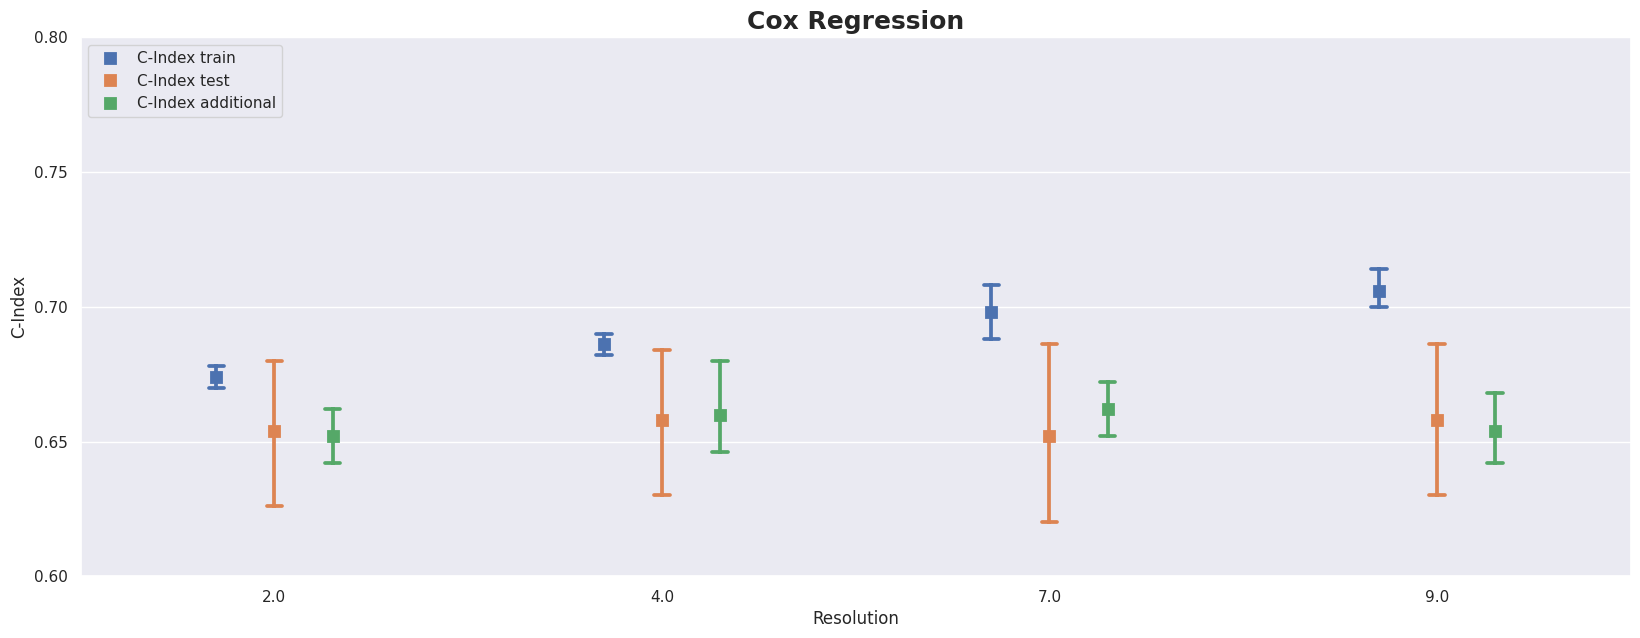

In [81]:
mean_ci_cox(df_summary_all, ylim=[0.6, 0.8])

## Get WSI in with top 10 clusters (2high-2low risk patients)

In [93]:
''' ###### Visualize WSI Cluster Samples ######### '''
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    # if TCGA-MESO put - instead of _.
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, groupby, slide, img_size, downsample, img_dicts, colors, pad_pixels=50, legend_margin=1000):
    slide_indices  = frame[frame.slides==slide].indexes.values.tolist()
    slide_tiles    = frame[frame.slides==slide].tiles.values.tolist()
    slide_sets     = frame[frame.slides==slide].original_set.values.tolist()
    slide_clusters = frame[frame.slides==slide][groupby].values.tolist()

    # Get size of the WSI.
    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set, cluster in zip(slide_indices, slide_tiles, slide_sets, slide_clusters):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)

        if cluster == 'Others':
            color = colors[-1]
        else:
            color = colors[int(cluster)]
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    wsi_padded = np.pad(wsi[:, :, 0], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_padded_total = np.zeros(list(wsi_padded.shape) + [3])
    wsi_padded_total[:, :, 0] = wsi_padded
    wsi_padded_total[:, :, 1] = np.pad(wsi[:, :, 1], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_padded_total[:, :, 2] = np.pad(wsi[:, :, 2], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')

    wsi_padded = np.pad(wsi_c[:, :, 0], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_c_padded_total = np.zeros(list(wsi_padded.shape) + [3])
    wsi_c_padded_total[:, :, 0] = wsi_padded
    wsi_c_padded_total[:, :, 1] = np.pad(wsi_c[:, :, 1], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_c_padded_total[:, :, 2] = np.pad(wsi_c[:, :, 2], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    return wsi_padded_total, wsi_c_padded_total, slide_clusters


In [94]:
# Taking slide and tile data from unfiltered dataset.
dataset_temp = 'Meso'
h5_path_temp = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset_temp, dataset_temp)
frame, dim_columns, rest_columns = representations_to_frame(h5_path_temp, meta_field='case_Id')
df_tile_slide_set = frame[['slides', 'case_Id', 'tiles', 'indexes', 'original_set']]

# Taking the slide and tile HPC numbers from adatas
adatas_path_whole = h5_complete_path.split('/hdf5_')[0] + '/{}/adatas/'.format(meta_folder)
_, frame_clusters, leiden_clusters_whole = read_csvs(adatas_path_whole, matching_field, groupby, fold_number, [[''],[''],['']], h5_path_temp, None, additional_as_fold=False, force_fold=None)
from IPython.display import clear_output
clear_output()

In [95]:
from data_manipulation.data import Data
data = Data(dataset=dataset_temp, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

Meso


In [96]:
# Selecting the high_low risk slide and patients
fold, resolution = 4, '2p0'
clustered_df = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
clustered_df['hazard'] = cph.predict_partial_hazard(clustered_df.drop(['Stage', 'Sex', 'age', 'Meso_type', 'case_Id', 'os_event_data', 'os_event_ind'], axis=1))
clustered_df.sort_values(by='hazard', ascending=False, inplace=True)
high_0, high_1 = clustered_df['case_Id'].values[:2]
low_0, low_1 = clustered_df['case_Id'].values[-2:]
print('low hazrads patients:', low_0, low_1)
print('high hazards patients', high_0, high_1)
for id in [low_0, low_1, high_0, high_1]:
    print('Case Id:',id)
    print(frame_clusters[frame_clusters.case_Id==id].samples.unique())


low hazrads patients: 280 173
high hazards patients 273 191
Case Id: 280
['MESO_280_23' 'MESO_280_19' 'MESO_280_25' 'MESO_280_26' 'MESO_280_20'
 'MESO_280_18']
Case Id: 173
['MESO_173_15' 'MESO_173_13' 'MESO_173_18' 'MESO_173_21' 'MESO_173_14'
 'MESO_173_16' 'MESO_173_11' 'MESO_173_17' 'MESO_173_20' 'MESO_173_12'
 'MESO_173_19']
Case Id: 273
['MESO_273_3' 'MESO_273_5' 'MESO_273_2' 'MESO_273_6']
Case Id: 191
['MESO_191_5' 'MESO_191_12' 'MESO_191_4' 'MESO_191_2' 'MESO_191_3'
 'MESO_191_8']


In [ ]:

for id in [low_0, low_1, high_0, high_1]:
    list = frame_clusters[frame_clusters.case_Id==id].samples.unique()
    for slide in list:
        sns.color_palette("tab20")
        temp = frame_clusters[frame_clusters.slides == slide]
        ten_top_hpc = temp[groupby].value_counts().head(10)
        goal_clusters_df = temp[temp[groupby].isin(ten_top_hpc.index.values)]
        goal_clusters_df = goal_clusters_df[[groupby, 'slides', 'tiles']]
        final_df = df_tile_slide_set.merge(goal_clusters_df, on=['slides', 'tiles'], how='outer')
        final_df[groupby] = final_df[groupby].fillna('Others')

        sns.countplot(x='leiden_2.0', data=final_df, palette='tab20')
        plt.title('Slide: {}'.format(slide))
        # plt.savefig(os.path.join(figure_path, 'slide_{}_cluster_distribution.png'.format(slide)), dpi=500, bbox_inches='tight')
        plt.show()
        break

In [100]:
# from models.visualization.clusters import get_wsi_arrays
from skimage.transform import resize
from matplotlib.lines        import Line2D
# 'MESO_165_4', 'MESO_361_28', 'MESO_367_31', 'MESO_367_26', 'MESO_367_30', 'MESO_165_11'
# slides = ['MESO_165_4', 'MESO_361_28', 'MESO_367_31', 'MESO_367_26', 'MESO_367_30', 'MESO_165_11' ]
groupby = 'leiden_2.0'
for id in [low_0, low_1, high_0, high_1]:
    slides = frame_clusters[frame_clusters.case_Id==id].slides.unique()
    for slide in slides:
        # Extracting 10 top HPCs for each slide
        temp = frame_clusters[frame_clusters.slides == slide]
        ten_top_hpc = temp[groupby].value_counts().head(10)
        goal_clusters_df = temp[temp[groupby].isin(ten_top_hpc.index.values)]
        goal_clusters_df = goal_clusters_df[[groupby, 'slides', 'tiles']]

        final_df = df_tile_slide_set.merge(goal_clusters_df, on=['slides', 'tiles'], how='outer')
        final_df[groupby] = final_df[groupby].fillna('Others')

        
        colors_ = np.unique(frame_clusters[groupby].astype(float).astype(str).values).tolist() + ['Others']
        colors = sns.color_palette('Paired', len(colors_))

        wsi, wsi_c, slide_clusters = get_wsi_arrays(final_df, groupby, slide, img_size=224, downsample=2, img_dicts=data_dicts, colors=colors, pad_pixels=0, legend_margin=1000)
        fontsize   = 30
        markersize = 15
        image_clusters, counts = np.unique(slide_clusters, return_counts=True)


        # for index in np.argsort
        # custom_lines = [Line2D([0], [0], color=, lw=markersize) for index in np.argsort(-counts)]
        
        names_lines, color_lines  = [], []
        others_flag = False
        for index in np.argsort(-counts):
            hpc = image_clusters[index]
            if hpc == 'Others':
                others_flag = True
            else:
                hpc = hpc.astype(float).astype(int)
                color = colors[hpc]
                annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
                ann_hpc = textwrap.fill(annotations[annotations['HPC'] == hpc]['Summary'].values[0] + ' ({})'.format(annotations[annotations['HPC'] == hpc]['main_pattern'].values[0]), width=80)
                ratio = goal_clusters_df[goal_clusters_df[groupby]==hpc].shape[0]/goal_clusters_df.shape[0]
                name = 'HPC %2s - Area(%s) %3s - %s' % (hpc, '%',np.round(ratio*100,2), ann_hpc)
                names_lines.append(name)
                color_lines.append(Line2D([0], [0], color=color, lw=markersize))
        
        if others_flag: 
            names_lines.append('Others')
            color_lines.append(Line2D([0], [0], color=colors[-1], lw=markersize))
        fig = plt.figure(figsize=(50, 50))
        for (_wsi, wsi_name) in [(wsi,'wsi'), (wsi_c,'wsi_c')]:
            dpi = 100
            height, width, _ = _wsi.shape
            figsize = width / float(dpi), height / float(dpi)
            
            
            if wsi_name == 'wsi_c':
                ax  = fig.add_subplot(1, 2, 1)
                
                legend = ax.legend(color_lines, names_lines, title='Histomorphological Phenotype Cluster\n(HPC)', loc='center left', ncol=1,
                                prop={'weight':'bold', 'size':fontsize}, title_fontproperties={'weight':'bold', 'size':fontsize*1.2}, bbox_to_anchor=(0.25, 1.5),fancybox=True, shadow=True)
                legend.get_frame().set_linewidth(5)
            elif wsi_name == 'wsi':
                ax  = fig.add_subplot(1, 2, 2)
                legend = None
            
            ax.imshow(_wsi/255.)
            ax.axis('off')

        # plt.show(fig)
        # plt.close(fig)
        fig.savefig(figure_path + '/%s_overlaid_wsi.jpg' % (slide), bbox_inches='tight', pad_inches=0)

		Whole Slide Image Resolution MESO_280_23: (5488, 5936)
		Whole Slide Image Resolution MESO_280_19: (5600, 5936)
		Whole Slide Image Resolution MESO_280_25: (5600, 5936)
		Whole Slide Image Resolution MESO_280_26: (5936, 6496)
		Whole Slide Image Resolution MESO_280_20: (5264, 5712)
		Whole Slide Image Resolution MESO_280_18: (5152, 5488)
		Whole Slide Image Resolution MESO_173_15: (4144, 7616)
		Whole Slide Image Resolution MESO_173_13: (3472, 5936)
		Whole Slide Image Resolution MESO_173_18: (4032, 7504)
		Whole Slide Image Resolution MESO_173_21: (4144, 7616)
		Whole Slide Image Resolution MESO_173_14: (5376, 6496)
		Whole Slide Image Resolution MESO_173_16: (4704, 4368)
		Whole Slide Image Resolution MESO_173_11: (3136, 7616)
		Whole Slide Image Resolution MESO_173_17: (4480, 7168)
		Whole Slide Image Resolution MESO_173_20: (4032, 6048)
		Whole Slide Image Resolution MESO_173_12: (3248, 7616)
		Whole Slide Image Resolution MESO_173_19: (4256, 6944)
		Whole Slide Image Resolution 

: 